# Black-Scholes avec Monte Carlo (Evaluation d’une option à barrière)

# Méthode Monte Carlo

Une façon de calculer le prix de l’option d’achat consiste à utiliser les méthodes de Monte Carlo. Le point de départ est de prendre l'équation de mouvement brownien pour l'action sous-jacente $S(t)$ :
$$
dS = S\,r dt +S\sigma dz\,,
$$

$$
S_{T} = S_{t}\exp\left(\left(r-\frac{1}{2}\sigma^{2}\right)(T-t) +\sigma \sqrt{T-t}\,z\right)\,,
$$
où $z$ est une variable suivant une distribution normale.

In [1]:
import numpy as np
import pandas as pd
from scipy import log,exp,sqrt,stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats.distributions import norm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def simulation(S0, r, vol, T, N, Nsim):
    dt = T/N
    paths = np.zeros((Nsim, N+1))
    paths[:,0] = S0
    for i in range (1, N+1):
        z = np.random.normal(0, 1, Nsim)
        paths[:, i] = paths[:,i-1] * np.exp((r - 0.5*vol**2) * dt 
                                            + vol * np.sqrt(dt) * z)
    return paths    

In [4]:
# Example 
S0 = 100  # Initial stock price
K = 105   # Strike price
barrier = 130  # Barrier level
r = 0.05   # Risk-free rate
vol = 0.2  # Volatility
T = 1      # Time to expiration
N = 1000  # Number of Monte Carlo paths
Nsim = 1000    # Number of steps in each path

On note que $S_{t}$ suit un mouvement brownien géométrique :

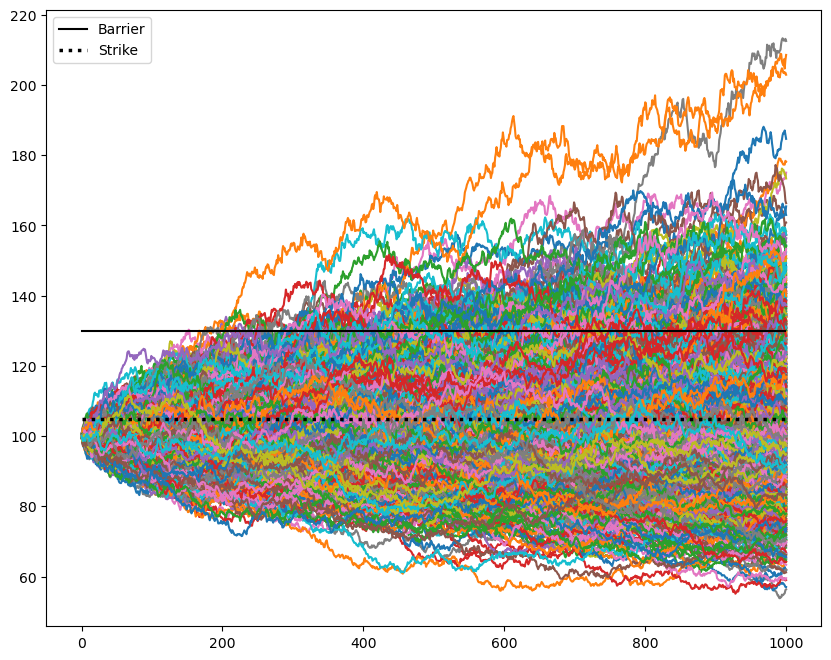

In [5]:
paths = simulation(S0, r, vol, T, N, Nsim)
plt.figure(figsize=(10,8))
plt.plot(paths.T)
plt.plot(np.arange(0,N), np.ones(N) * barrier, color = "black", label = "Barrier", lw = 1.5)
plt.hlines(K ,xmin=0,xmax= 1000,linestyle='dotted',colors='black',label = 'Strike', lw = 2.5)
#plt.hlines(S0 ,xmin=0,xmax= 1000,linestyle='dashed',colors='black',label = 'Stock price', lw = 2.5)
plt.legend()
plt.show()

In [6]:
paths = simulation(S0, r, vol, T, N, 100000)
final_prices = paths[:, -1]

On remarque également que $S_{i}$ a une distribution log-normale :

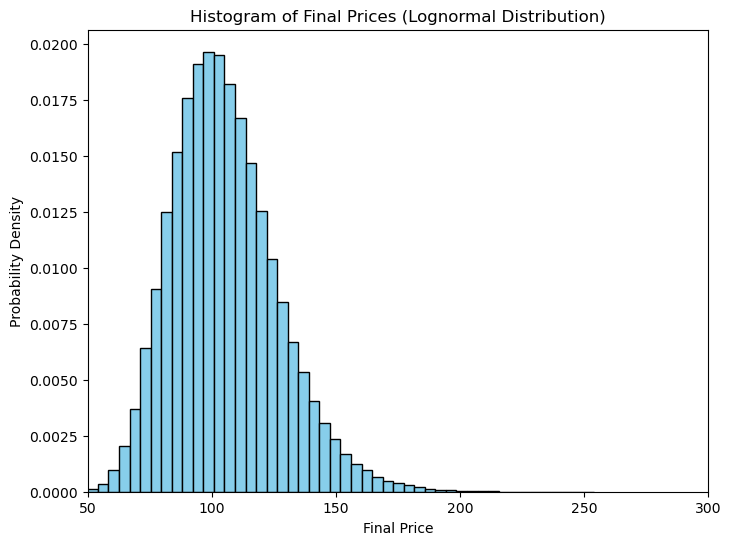

In [7]:
plt.figure(figsize=(8, 6))  # Set the figure size
plt.hist(final_prices, bins=50, color='skyblue', edgecolor='black', alpha=1, density = True)  # Adjust the number of bins, color, edge color, and transparency
plt.xlabel('Final Price')  # Set x-axis label
plt.ylabel('Probability Density')  # Set y-axis label
plt.title('Histogram of Final Prices (Lognormal Distribution)')  # Set the title
plt.xlim(50, 300)
plt.show() 

In [8]:
def Payoff(paths, K, barrier, type = 'call'):
    N = paths.shape[1] - 1
    
    if (type == 'call'):
        payoff = np.maximum(paths[:, N] - K, 0)
    else:
        payoff = np.maximum(K - paths[:, N], 0)
        
    barrierHit = np.any(paths >= barrier, axis = 1) 
    payoff[barrierHit] = 0

    return payoff

In [9]:
def Price(S0, r, vol, T, K, barrier, N, Nsim, type = 'call'):
    dt = T/N
    paths = simulation(S0, r, vol, T, N, Nsim)
    
    payoff = Payoff(paths, K, barrier, type = 'call')
    Price = np.exp(-r * dt)*np.mean(payoff)
    
    return Price

In [10]:
Price(S0, r, vol, T, K, barrier, N, 100000, type = 'call')

2.1599670068212906

# Solution Exacte

Le modèle Black-Scholes affirme que les prix des actifs en fonction du temps
suivent un mouvement brownien géométrique:
$$
dS = S \mu dt + S \sigma dz\,.
$$

La solution de l'équation de Black-Scholes pour une option d'achat européenne $C(S,t)$, étant donné la maturité $T$ et le prix d'exercice $K$ est donnée par :
$$
C(S,t) = S\, N(d_{1}) - K\,e^{-r(T-t)}N(d_{2})\,,
$$
où:
$$
d_{1} = \frac{\ln(S/K) + \left(r + \frac{\sigma^{2}}{2}\right)\left(T-t\right)}{\sigma\sqrt{T-t}}\,,
$$
$$
d_{2} = \frac{\ln(S/K) + \left(r - \frac{\sigma^{2}}{2}\right)\left(T-t\right)}{\sigma\sqrt{T-t}}\,,
$$
and where $N(d)$ is the cumulative normal distribution:
$$
N(d)= \frac{1}{\sqrt{2\pi}}\int_{-d}^{\infty} dx\; e^{-x^{2}/2}\,.
$$

Concentrons-nous sur la solution exacte pour le prix de l'option d'achat $C(S,t)$.

In [11]:
def black_scholes(S,K,r,vol,T, t):
    
    d1 = (log(S/K)+(r+((vol**2)/2))*(T-t))/(vol*sqrt((T-t)))
    d2 = d1-vol*sqrt((T-t))
    
    ST = S*stats.norm.cdf(d1) - K*exp(-r*(T-t))*stats.norm.cdf(d2)
    
    return ST

Nous traçons quelques solutions C en fonction de t. Nous choisissons $S=100$ et utilisons $K=95, 98, 100, 105$. Dans la suite de ce code, nous définirons toujours $T=1, r=0.05, \sigma = 0.2$.

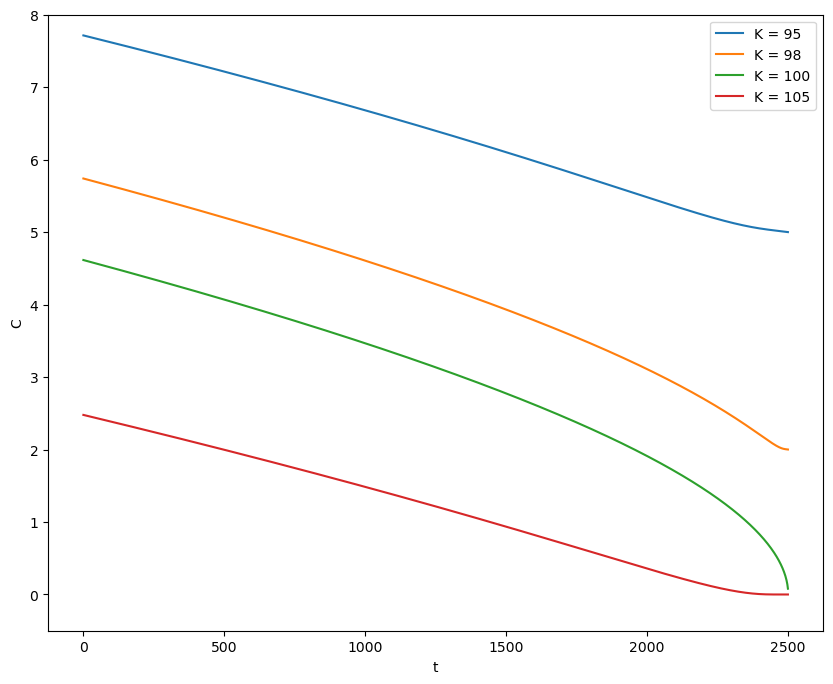

In [12]:
t = np.arange(0.75, 1.0, 0.0001)

plt.figure(figsize=(10, 8))
sns.lineplot(black_scholes(100, 95, 0.05, 0.2, 1, t), label='K = 95')
sns.lineplot(black_scholes(100, 98, 0.05, 0.2, 1, t), label='K = 98')
sns.lineplot(black_scholes(100, 100, 0.05, 0.2, 1, t), label='K = 100')
sns.lineplot(black_scholes(100, 105, 0.05, 0.2, 1, t), label='K = 105')

plt.xlabel('t')
plt.ylabel('C')
plt.ylim(-0.5, 8)

plt.legend()
plt.show()

En particulier, pour $T - t = 0$, nous avons la fonction standard de l'option d'achat à l'échéance:

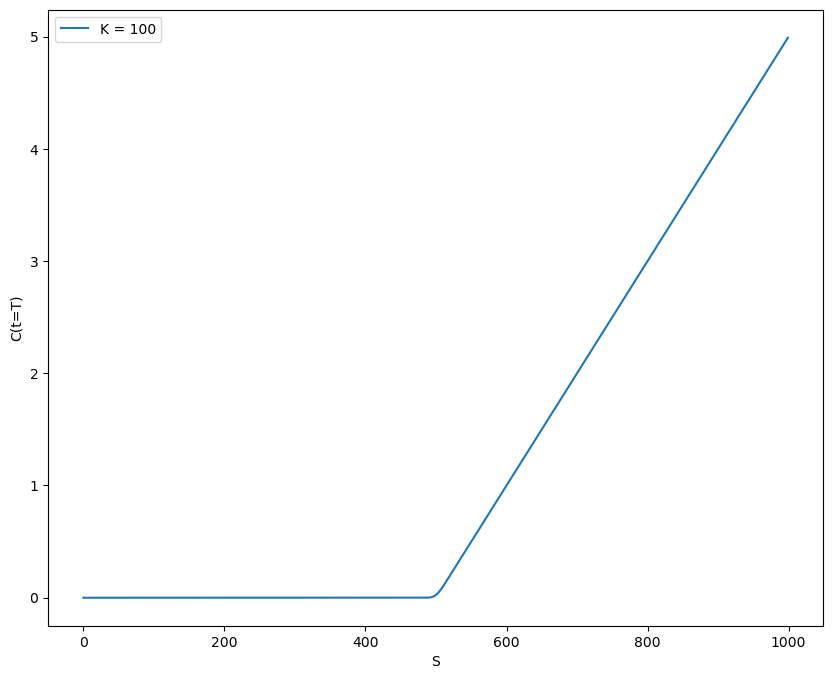

In [13]:
s = np.arange(95, 105, 0.01)

plt.figure(figsize = (10,8))
sns.lineplot(black_scholes(s,100,0.05,0.2,1,0.99999), label = 'K = 100')

plt.xlabel('S')
plt.ylabel('C(t=T)')

plt.legend()
plt.show()

# Evaluation d’options européennes à barrière

   ##### Parameters:
    k = strike price
    s = stock price
    h = barrier price
    t = t/T = time to maturity
    r = risk-less short rate
    sig = volatility of stock value
    payoff = "in" or "out" options
    i: call = 1  put = -1
    n：down = 1  up = -1

In [14]:
def bsm_barrier_option(k, s, h, t, r, sig, payoff, n, i):

    la = (r + ((sig ** 2) / 2)) / (sig ** 2)
    z = math.log(h / s, math.e) / (sig * math.sqrt(t)) + la * sig * math.sqrt(t)
    x1 = math.log(s / k, math.e) / (sig * math.sqrt(t)) + la * sig * math.sqrt(t)
    x2 = math.log(s / h, math.e) / (sig * math.sqrt(t)) + la * sig * math.sqrt(t)
    y1 = math.log((h ** 2) / (s * k), math.e) / (sig * math.sqrt(t)) + la * sig * math.sqrt(t)
    y2 = math.log(h / s, math.e) / (sig * math.sqrt(t)) + la * sig * math.sqrt(t)

    A = i * s * math.exp(-r * t) * norm.cdf(i * x1) - i * k * math.exp(-r * t) * norm.cdf(
        i * x1 - i * sig * math.sqrt(t))
    B = i * s * math.exp(-r * t) * norm.cdf(i * x2) - i * k * math.exp(-r * t) * norm.cdf(
        i * x2 - i * sig * math.sqrt(t))
    C = i * s * math.exp(-r * t) * (h / s) ** (2 * la + 2) * norm.cdf(n * y1) - i * k * math.exp(-r * t) * ((
            h / s) ** (2 * la)) * norm.cdf(n * y1 - n * sig * math.sqrt(t))
    D = i * s * math.exp(-r * t) * ((h / s) ** (2 * la + 2)) * norm.cdf(n * y2) - i * k * math.exp(-r * t) * ((
            h / s) ** (2 * la)) * norm.cdf(n * y2 - n * sig * math.sqrt(t))
    E = math.exp(-r * t) * (norm.cdf(n * x2 - n * sig * math.sqrt(t)) - ((h / s) ** (2 * la)) * norm.cdf(
        n * y2 - n * sig * math.sqrt(t)))
    F = (((h / s) ** (la)) * norm.cdf(n * z) + ((h / s) ** la) * norm.cdf(
        n * z - 2 * n * la * sig * math.sqrt(t)))

    value = 0
    if payoff == "in":
        if n == 1 and i == 1:  # down-and-in call options
            if k > h:
                value = C + E

            else:
                value = A - B + D + E

        elif n == -1 and i == 1:  # up-and-in call options
            if k > h:
                value = A + E
            else:
                value = B - C + D + E

        elif n == 1 and i == -1:  # down-and-in put options
            if k > h:
                value = B - C + D + E
            else:
                value = A + E

        elif n == -1 and i == -1:  # up-and-in put options
            if k > h:
                value = A - B + D + E
            else:
                value = C + E

    else:
        if n == 1 and i == 1:  # down-and-out call options
            if k > h:
                value = A - C + F

            else:
                value = B - D + F

        elif n == -1 and oi == 1:  # up-and-out call options
            if k > h:
                value = F
            else:
                value = A - B + C - D + F

        elif n == 1 and i == -1:  # down-and-out put options
            if k > h:
                value = A - B + C - D + F
            else:
                value = F

        elif n == -1 and oi == -1:  # up-and-out put options
            if k > h:
                value = B - D + F
            else:
                value = A - C + F

    return value

In [15]:
Price_Exact = bsm_barrier_option(105, 100, 130, 0.45, 0.01, 0.2, "in", -1, 1)

In [16]:
print('Monte Carlo:',Price(100, 0.05, 0.2, 1, 105, 130, 100, 100000, type = 'call'))
print('Exact: ',Price_Exact)

Monte Carlo: 2.35085936054267
Exact:  2.387179053227456


In [17]:
S = []
df = pd.DataFrame(columns=['Iter','BSc'])

for i in range(1, 2000, 10):
    s = Price(100, 0.05, 0.2, 1, 105, 130, 100, i, type = 'call')
    S.append(s)
    df = df.append({'Iter': i, 'BSc': s}, ignore_index=True)

Nous pouvons tracer comment la valeur de l’option d’achat à barrière de Monte Carlo converge vers la valeur exacte à mesure que le nombre d’itérations augmente :

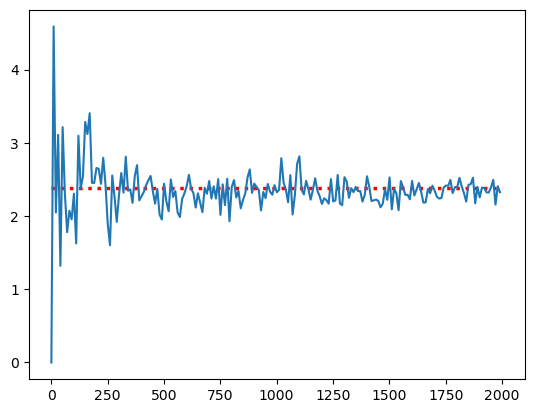

In [18]:
plt.hlines(Price_Exact ,xmin=0,xmax= 2000,linestyle='dotted',colors='red',label = 'Exact', lw = 2.5)
plt.plot(df.set_index('Iter'),lw = 1.5, label = 'Monte Carlo')